In [1]:
#Define my working directory (important for modules)
import os
os.chdir('/nfs/annie/eelse/scripts/jupyter')

In [2]:
%matplotlib inline
import cartopy.feature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr
import xesmf as xe
import mw_protocol.plotting as plotting
import mw_protocol.routing as routing
import mw_protocol.glac1d_toolbox as tb

# Demonstration routing algorithm

**Objective** : Algorithm to transform GLAC1D transient ice sheet reconstruction in a transient meltwater discharge mask given a routing map and a land sea mask. Operations : 
- Transform ice thickness differences in volumetric fluxes (m -> m3/s, -26,0). Remove negative values.
- Smooth the results. Different modes possible (differential by default).
- Routing the ice differences using the pointer file (conservation of total flux).
- Regrid to HadCM3.
- Deal with points overlapping the land sea mask to reroute them to the nearest sea point.

## Inputs

**Land Sea Mask** : experiment name <-> time table is available on GitHub.  

In [3]:
ds_lsm = xr.open_dataset('/nfs/annie/earpal/database/experiments/temes/inidata/temes.qrparm.omask.nc') #temes is the one from 18ka

lon_lsm, lat_lsm = ds_lsm.longitude.values, ds_lsm.latitude.values
lon_lsm_b, lat_lsm_b = tb.create_coordinate_edges(lon_lsm), lat_lsm
lsm = ds_lsm.lsm.values

ds_lsm

<xarray.Dataset>
Dimensions:     (longitude: 288, latitude: 144)
Coordinates:
  * longitude   (longitude) float32 0.0 1.25 2.5 3.75 ... 356.2 357.5 358.8
  * latitude    (latitude) float32 -89.38 -88.12 -86.88 ... 86.88 88.12 89.38
Data variables:
    lsm         (latitude, longitude) float32 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    depthlevel  (latitude, longitude) float32 ...
    depthdepth  (latitude, longitude) float32 ...
Attributes:
    title:    Produced using writenc6 program by PJV

Text(0.5, 1.0, 'Land sea mask at 18 kya')

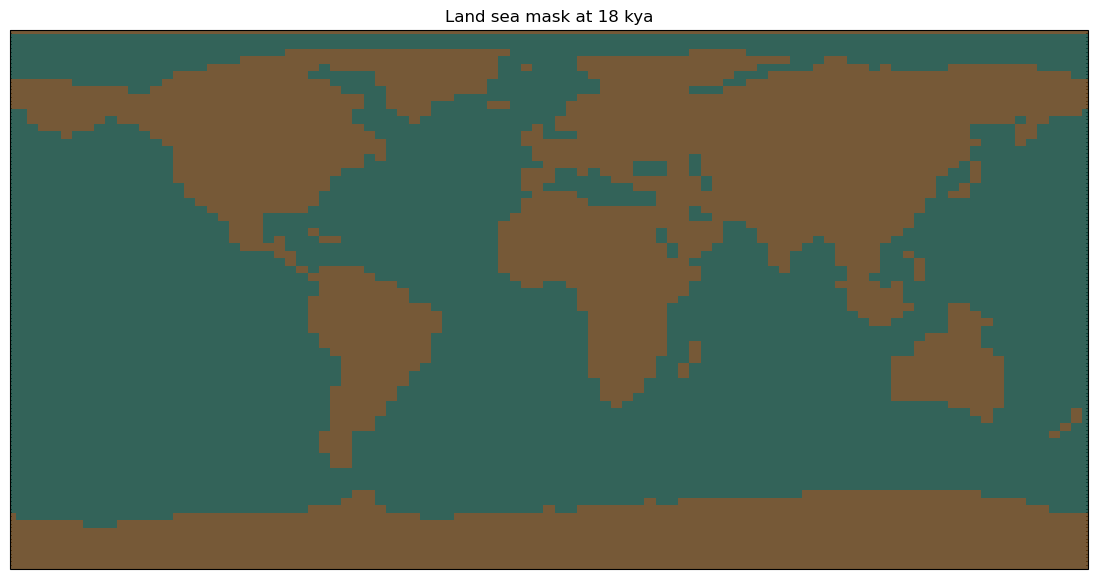

In [4]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))

cmap = axMap.pcolormesh(lon_lsm_b, lat_lsm_b, lsm, transform=ccrs.PlateCarree(), cmap="BrBG_r", alpha=0.8)
axMap.set_global()
axMap.set_title("Land sea mask at 18 kya")

**Ice sheet reconstruction** : 2 dimensional time serie of ice thickness (*HGLOBH*)

In [5]:
ds_hice = xr.open_dataset('/nfs/annie/eeymr/work/data/mw_protocol/GLAC1DHiceF26.nc')

lon_glac1D, lat_glac1D, t_glac1d = ds_hice.XLONGLOBP5.values, ds_hice.YLATGLOBP25.values, ds_hice.T122KP1.values
lon_glac1D_b, lat_glac1D_b = tb.create_coordinate_edges(lon_glac1D), lat_glac1D
mask_hice_26 = np.where(ds_hice.HGLOBH.sel(T122KP1=-26).values==0, np.NAN, ds_hice.HGLOBH.sel(T122KP1=-26).values)

ds_hice

<xarray.Dataset>
Dimensions:      (XLONGLOBP5: 720, YLATGLOBP25: 720, T122KP1: 261)
Coordinates:
  * XLONGLOBP5   (XLONGLOBP5) float64 180.2 180.8 181.2 ... 538.8 539.2 539.8
  * YLATGLOBP25  (YLATGLOBP25) float64 -89.88 -89.62 -89.38 ... 89.62 89.88
  * T122KP1      (T122KP1) float64 -26.0 -25.9 -25.8 -25.7 ... -0.2 -0.1 0.0
Data variables:
    HGLOBH       (T122KP1, YLATGLOBP25, XLONGLOBP5) float64 ...
Attributes:
    history:      FERRET V6.96   10-Aug-17
    Conventions:  CF-1.6
    title:        GLAC1D ice thickness Field, Lev Tarasov

In [11]:
t_glac1d #seems to be the time series of GLAC1D history

array([-26. , -25.9, -25.8, -25.7, -25.6, -25.5, -25.4, -25.3, -25.2,
       -25.1, -25. , -24.9, -24.8, -24.7, -24.6, -24.5, -24.4, -24.3,
       -24.2, -24.1, -24. , -23.9, -23.8, -23.7, -23.6, -23.5, -23.4,
       -23.3, -23.2, -23.1, -23. , -22.9, -22.8, -22.7, -22.6, -22.5,
       -22.4, -22.3, -22.2, -22.1, -22. , -21.9, -21.8, -21.7, -21.6,
       -21.5, -21.4, -21.3, -21.2, -21.1, -21. , -20.9, -20.8, -20.7,
       -20.6, -20.5, -20.4, -20.3, -20.2, -20.1, -20. , -19.9, -19.8,
       -19.7, -19.6, -19.5, -19.4, -19.3, -19.2, -19.1, -19. , -18.9,
       -18.8, -18.7, -18.6, -18.5, -18.4, -18.3, -18.2, -18.1, -18. ,
       -17.9, -17.8, -17.7, -17.6, -17.5, -17.4, -17.3, -17.2, -17.1,
       -17. , -16.9, -16.8, -16.7, -16.6, -16.5, -16.4, -16.3, -16.2,
       -16.1, -16. , -15.9, -15.8, -15.7, -15.6, -15.5, -15.4, -15.3,
       -15.2, -15.1, -15. , -14.9, -14.8, -14.7, -14.6, -14.5, -14.4,
       -14.3, -14.2, -14.1, -14. , -13.9, -13.8, -13.7, -13.6, -13.5,
       -13.4, -13.3,

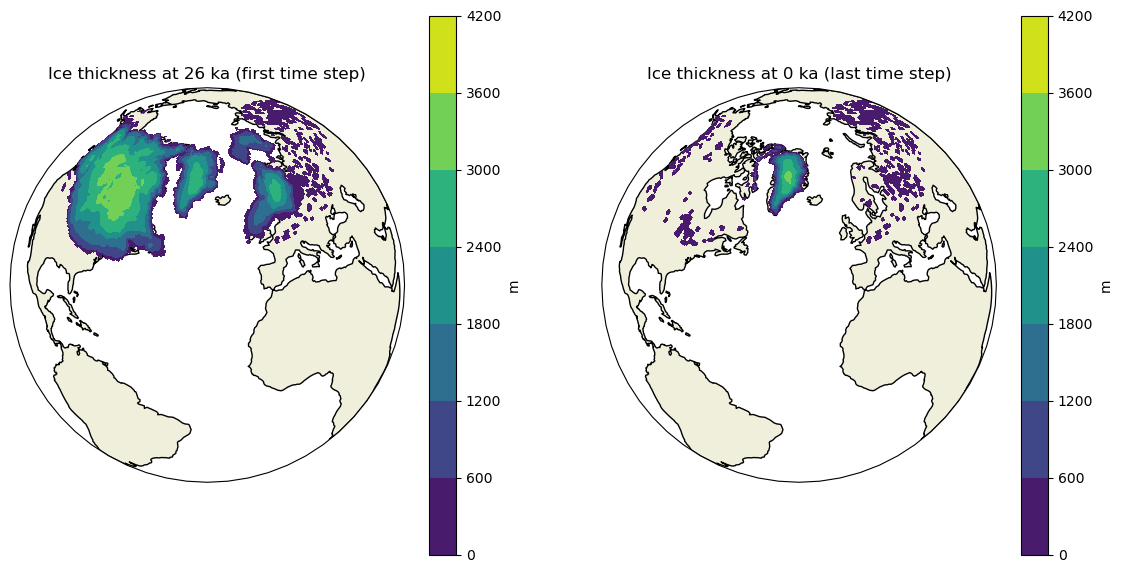

In [10]:
projection_map = ccrs.Orthographic(central_longitude=-30.0, central_latitude=40.0)
figMap,(axStart, axEnd) = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection':projection_map}, figsize=(14,7))

cf_26 = axStart.contourf(lon_glac1D, lat_glac1D, mask_hice_26, transform=ccrs.PlateCarree())
axStart.set_global()
axStart.set_title("Ice thickness at 26 ka (first time step)")
axStart.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
figMap.colorbar(mappable=cf_26, ax=axStart, label="m")

mask_hice_0 = ds_hice.HGLOBH.sel(T122KP1=-0).values
mask_hice_0 = np.where(mask_hice_0==0, np.NAN, mask_hice_0)
cf_0 = axEnd.contourf(lon_glac1D, lat_glac1D, mask_hice_0, transform=ccrs.PlateCarree())
axEnd.set_global()
axEnd.set_title("Ice thickness at 0 ka (last time step)")
axEnd.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
figMap.colorbar(mappable=cf_0, ax=axEnd, label="m")

**Routing map** : 2 dimensional routing map of water basin. *IX* is the longitude index and *JY* is the latitude index, conversion based on provided readme file (*/nfs/annie/eeymr/work/data/Proj_GLAC1D/routed_fwf/GLAC1Dpointer_README.txt*)

In [13]:
ds_pointer = xr.open_dataset('/nfs/annie/eeymr/work/data/mw_protocol/GLAC1DdrainagePointerF26ka.nc')

# Indexes to coordinates conversion
IX_lon = ds_pointer.IX.sel(T40H1=-26).values*0.5 - 180.25 + 360
JY_lat = 90.125 - ds_pointer.JY.sel(T40H1=-26).values*0.25 

ds_pointer

<xarray.Dataset>
Dimensions:      (XLONGLOBP5: 720, YLATGLOBP25: 720, T40H1: 261)
Coordinates:
  * XLONGLOBP5   (XLONGLOBP5) float64 180.2 180.8 181.2 ... 538.8 539.2 539.8
  * YLATGLOBP25  (YLATGLOBP25) float64 -89.88 -89.62 -89.38 ... 89.62 89.88
  * T40H1        (T40H1) float64 -26.0 -25.9 -25.8 -25.7 ... -0.3 -0.2 -0.1 0.0
Data variables:
    IX           (T40H1, YLATGLOBP25, XLONGLOBP5) float32 ...
    JY           (T40H1, YLATGLOBP25, XLONGLOBP5) float32 ...
Attributes:
    history:      FERRET V6.96   10-Aug-17
    Conventions:  CF-1.6
    title:        GLAC1D drainage Pointer Field, Lev Tarasov

(lon,lat) [index_lon,index_lat] : (275.25, 47.625) [(190, 550)] -> (286.75, 38.375) [(213.0, 513.0)]
(lon,lat) [index_lon,index_lat] : (272.75, 29.375) [(185, 477)] -> (272.75, 29.375) [(185.0, 477.0)]
(lon,lat) [index_lon,index_lat] : (330.25, -64.875) [(300, 100)] -> (330.25, -64.875) [(300.0, 100.0)]


Text(0.5, 1.0, 'Sample routing points')

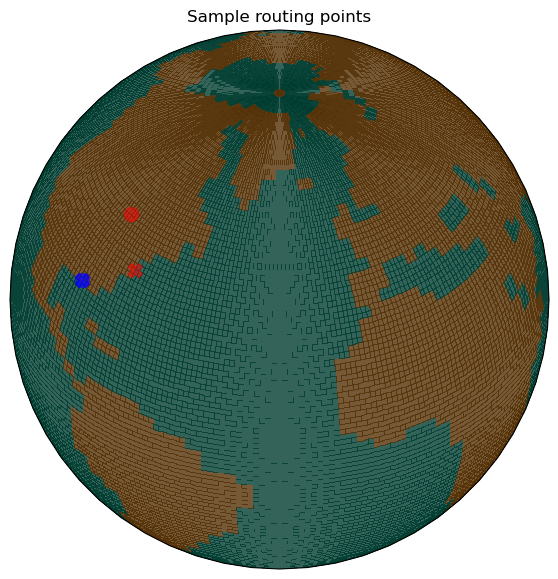

In [14]:
projection_map = ccrs.Orthographic(central_longitude=-30.0, central_latitude=40.0)
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(7,7))

axMap.pcolormesh(lon_lsm_b, lat_lsm_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.8)

# On land
i, j = 190,550
axMap.scatter(lon_glac1D[i], lat_glac1D[j], transform=ccrs.PlateCarree(), s=100, c="r", alpha=0.5)
axMap.scatter(IX_lon[j,i], JY_lat[j,i], transform=ccrs.PlateCarree(), s=100, c="r", alpha=0.5, marker="X")
i_glac1D, j_glac1D = 2*(IX_lon[j,i] -180.25), 4*(JY_lat[j,i] + 89.875)
print(f"(lon,lat) [index_lon,index_lat] : {lon_glac1D[i], lat_glac1D[j]} [{i,j}] -> {IX_lon[j,i], JY_lat[j,i]} [{i_glac1D, j_glac1D}]")

# On the edge of the land sea mask
i, j = 185, 477
axMap.scatter(lon_glac1D[i], lat_glac1D[j], transform=ccrs.PlateCarree(), s=100, c="b", alpha=0.5)
axMap.scatter(IX_lon[j,i], JY_lat[j,i], transform=ccrs.PlateCarree(), s=100, c="b", alpha=0.5, marker="X")
i_glac1D, j_glac1D = 2*(IX_lon[j,i] -180.25), 4*(JY_lat[j,i] + 89.875)
print(f"(lon,lat) [index_lon,index_lat] : {lon_glac1D[i], lat_glac1D[j]} [{i,j}] -> {IX_lon[j,i], JY_lat[j,i]} [{i_glac1D, j_glac1D}]")

# In the ocean
i, j = 300,100
axMap.scatter(lon_glac1D[i], lat_glac1D[j], transform=ccrs.PlateCarree(), s=100, c="g", alpha=0.5)
axMap.scatter(IX_lon[j,i], JY_lat[j,i], transform=ccrs.PlateCarree(), s=100, c="g", alpha=0.5, marker="X")
i_glac1D, j_glac1D = 2*(IX_lon[j,i] -180.25), 4*(JY_lat[j,i] + 89.875)
print(f"(lon,lat) [index_lon,index_lat] : {lon_glac1D[i], lat_glac1D[j]} [{i,j}] -> {IX_lon[j,i], JY_lat[j,i]} [{i_glac1D, j_glac1D}]")

axMap.set_global()
axMap.set_title("Sample routing points")

## Routing method

In a script, the routing method should be called as follows (we limit the number of steps here to prevent unecessecary computation time). The rest of the notebook will be decomposed to understand each steps individually.

__ Routing algorithm
__ Computation time step : 0.
Mode not recognized
____ Routing method.
____ Overlapping method with double-cross mode.
____ Applying mask processing with differential mode.
__ Computation time step : 1.
Mode not recognized
____ Routing method.
____ Overlapping method with double-cross mode.
____ Applying mask processing with differential mode.


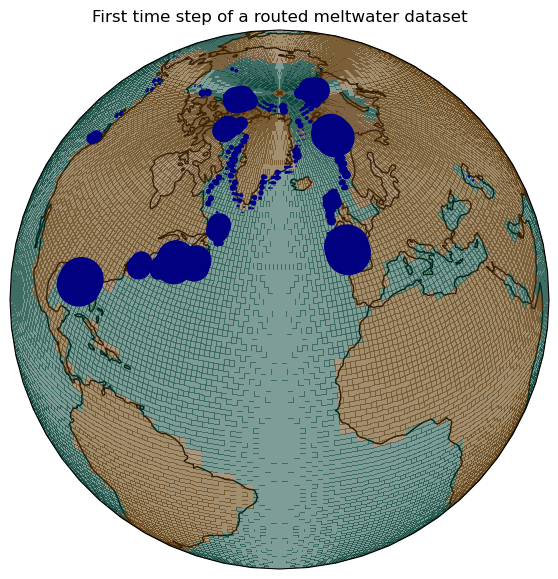

In [15]:
routed_mw = routing.routing(ds_hice, ds_pointer, ds_lsm, mode_flux="Volume", mode_lon="double",
                            mode_shape="cross", mode_smooth="differential", t_debug=2)

projection_map = ccrs.Orthographic(central_longitude=-30.0, central_latitude=40.0)

figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(7,7))

axMap.pcolormesh(lon_lsm_b, lat_lsm_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)

x,y,s = plotting.scatter_mask(routed_mw[0])
axMap.scatter(lon_lsm[x], lat_lsm[y], transform=ccrs.PlateCarree(), s=s, color="navy")
axMap.set_global()
axMap.set_title("First time step of a routed meltwater dataset")
axMap.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

## Conversion and Routing Algoritm

The first thing to do is to convert variation of the ice sheet into a meltwater flux for each points of the icesheet. Then we use the routing map to determine where will this water be released. We show here an example for one time step, but the complete method itterate through time to return a time serie.

In [19]:
# Conversion method
snap = -18 #L which timestep we want

t = np.where(t_glac1d == -18)[0][0]
converted_mask = routing.hi_to_discharge(ds_hice, t, "Volume")

# Routing method
ix, jy = ds_pointer.IX.sel(T40H1=snap).values, ds_pointer.JY.sel(T40H1=snap).values
routed_mask = routing.routing_method(converted_mask, ix, jy)

__ Computation time step : 80.
Mode not recognized
____ Routing method.


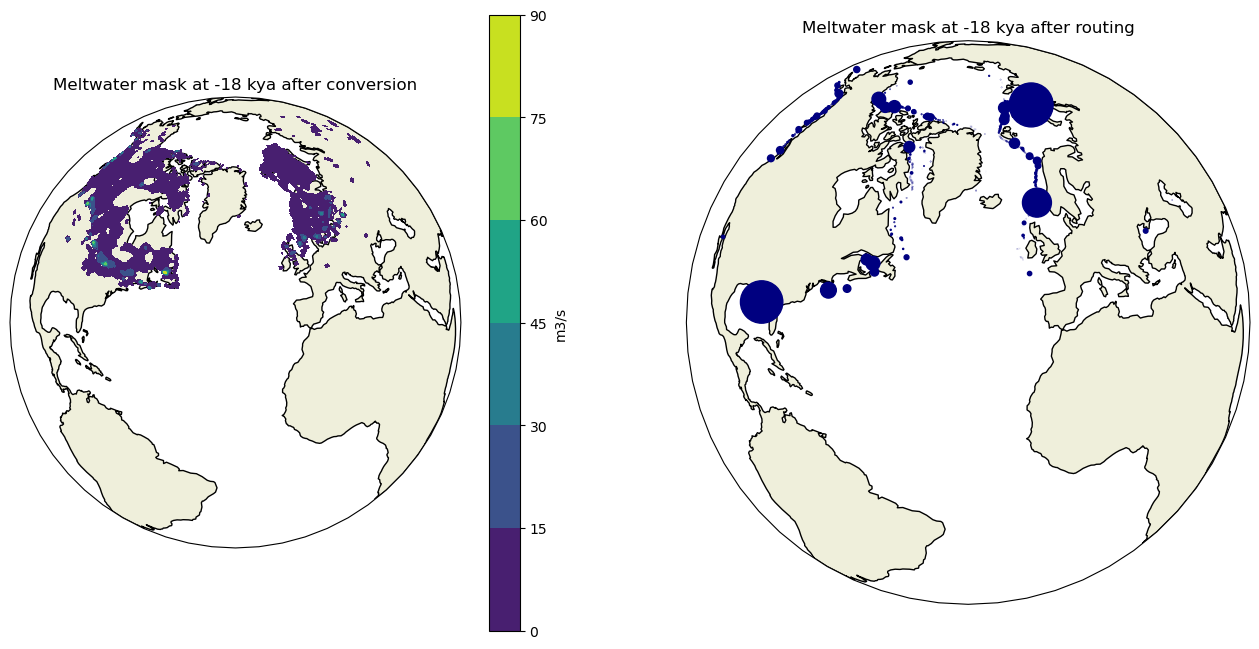

In [20]:
projection_map = ccrs.Orthographic(central_longitude=-30.0, central_latitude=40.0)
figMap,(axConverted, axRouted) = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection':projection_map}, figsize=(16,8))

converted_mask = np.where(converted_mask==0, np.NAN, converted_mask)
cf_converted = axConverted.contourf(lon_glac1D, lat_glac1D, converted_mask, transform=ccrs.PlateCarree())
axConverted.set_global()
axConverted.set_title(f"Meltwater mask at {snap} kya after conversion")
axConverted.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
figMap.colorbar(mappable=cf_converted, ax=axConverted, label="m3/s")

x,y,s = plotting.scatter_mask(routed_mask)
axRouted.scatter(lon_glac1D[x], lat_glac1D[y], transform=ccrs.PlateCarree(), s=s, color="navy")
axRouted.set_global()
axRouted.set_title(f"Meltwater mask at {snap} kya after routing")
axRouted.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

# TO DO : add size for size for scale in the scatter method.

## Regridding algorithm

The GLAC1D mask doesn't have the same dimension than the HadCM3 files : one should therefore regrid these files to the HadCM3 dimensions. To see a benchmark of the different available methods check misc_demo. We make sure at the end that the total flux have been conserved. The spreading of the release points results from the interpolation method.

In [21]:
regridder = tb.hadcm3_regridding_method(ds_hice, ds_lsm, reuse_weights=False)
hadcm3_mask = regridder(routed_mask)
hadcm3_mask = hadcm3_mask * np.sum(routed_mask) / np.sum(hadcm3_mask)  # to correct the total flux

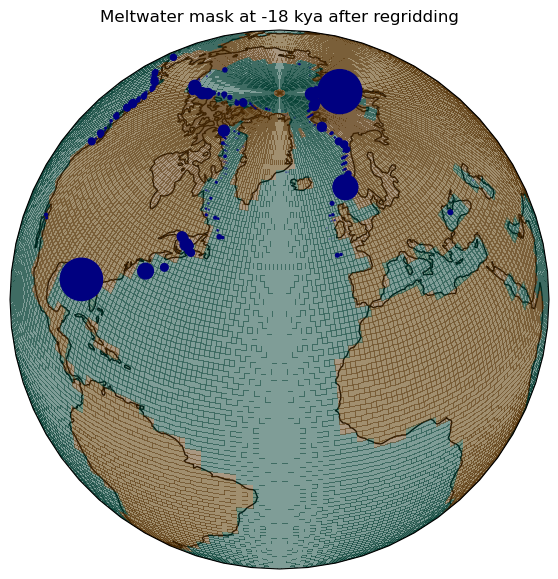

In [22]:
projection_map = ccrs.Orthographic(central_longitude=-30.0, central_latitude=40.0)

figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(7,7))

axMap.pcolormesh(lon_lsm_b, lat_lsm_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)

x,y,s = plotting.scatter_mask(hadcm3_mask)
axMap.scatter(lon_lsm[x], lat_lsm[y], transform=ccrs.PlateCarree(), s=s, color="navy")
axMap.set_global()
axMap.set_title(f"Meltwater mask at {snap} kya after regridding")
axMap.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

## Overlaping algorithm

The last plot highlight the fact that some relese points may overlap the lad sea mask, leading to unconsistencies in the simulation. We therefore use an algorithm to redirect meltwater discharge points to the closest sea point. Since the definition of close is not trivial and depend on the grid, we propose different algorithm that are described on *misc_demo*. The meltwater is equally distributed between points at the same distance.

Text(0.5, 1.0, 'Overlaping points with PI ice shet and 26ka land-sea mask')

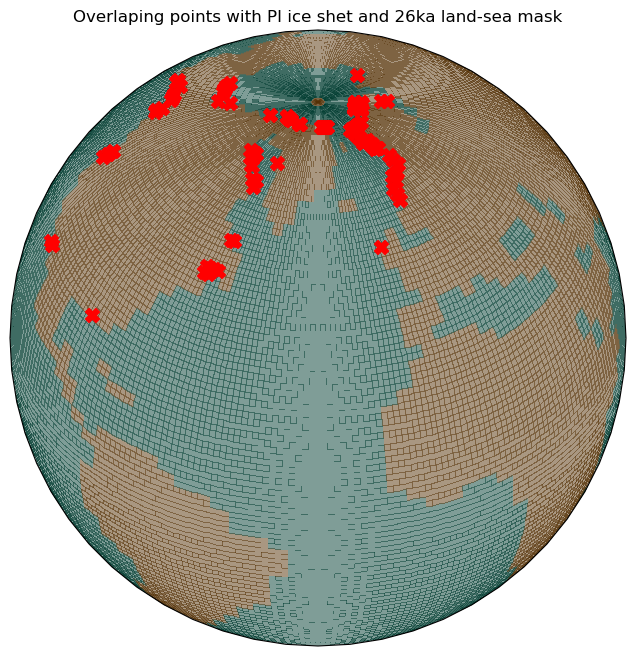

In [23]:
# Algorithm to get the overlaping points

lon_overlap, lat_overlap = [], [],
for i in range(len(lon_lsm)):
    for j in range(len(lat_lsm)):
        if hadcm3_mask[j, i] != 0 and lsm[j, i] == 1:
            lon_overlap.append(lon_lsm[i])
            lat_overlap.append(lat_lsm[j])
            
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(16,8))
cmap = axMap.pcolormesh(lon_lsm_b, lat_lsm_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
axMap.scatter(lon_overlap, lat_overlap, transform=ccrs.PlateCarree(), c="red", marker="X", s=100)
axMap.set_global()
axMap.set_title("Overlaping points with PI ice shet and 26ka land-sea mask")

We can check that the algorithm by plotting several sample points using this quick method (not in the package)

In [24]:
# Reprduce the overlaping algorithm but return the indexes
def sea_neighbours(i, j, mode_lon="double", mode_shape="cross"):
    n_i, n_j = len(lon_lsm), len(lat_lsm)
    radius, land_condition, i_sea_points, j_sea_points = 0, True, [], []
    while land_condition:
        for i_2 in range(- radius, radius + 1):
            for j_2 in routing.get_neighbours(radius, mode_lon, mode_shape, i_2):
                i_test = (i + i_2) % n_i
                j_test = min(max(j + j_2, 0), n_j - 1)
                if lsm[j_test, i_test] == 0:
                    i_sea_points.append(i_test)
                    j_sea_points.append(j_test)
                    land_condition = False
        radius += 1
    return i_sea_points, j_sea_points

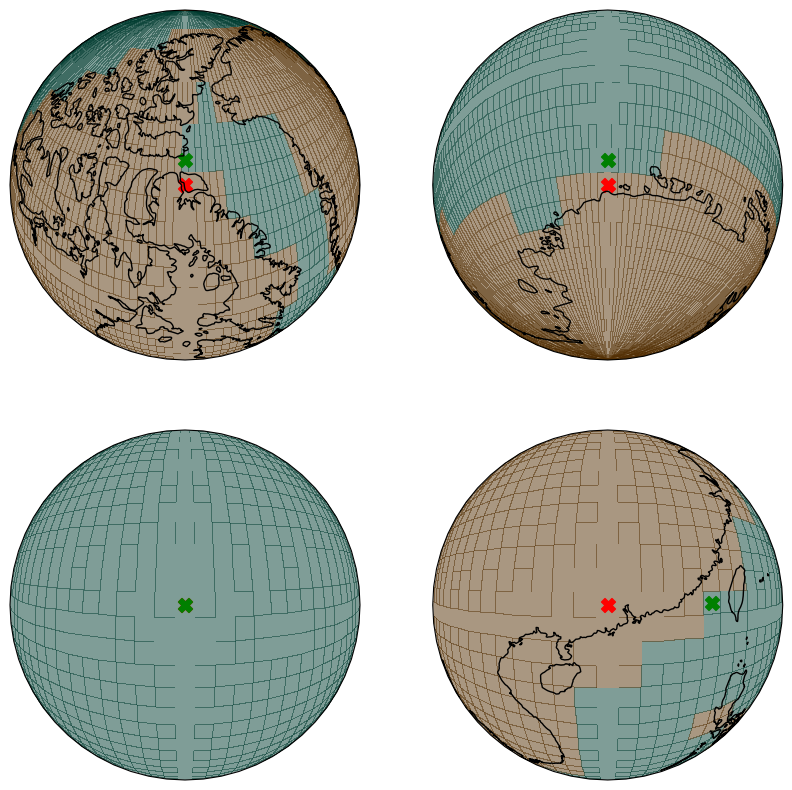

In [25]:
# On the edge
i_edge, j_edge = 224, 130
i_sea_edge,j_sea_edge = sea_neighbours(i_edge, j_edge)

# Double distribution
i_double, j_double = 180, 12
i_sea_double,j_sea_double = sea_neighbours(i_double, j_double)

# In the ocean
i_ocn, j_ocn = 162, 100
i_sea_ocn,j_sea_ocn = sea_neighbours(i_ocn, j_ocn)

# On land
i_lnd, j_lnd = 90, 90
i_sea_lnd,j_sea_lnd = sea_neighbours(i_lnd, j_lnd)


figMap = plt.figure(figsize=(10,10))

axEdge = plt.subplot(221, projection=ccrs.NearsidePerspective(central_longitude=lon_lsm[i_edge], central_latitude=lat_lsm[j_edge],
                                                                 satellite_height=300000))
axEdge.pcolormesh(lon_lsm_b, lat_lsm_b, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
axEdge.scatter(lon_lsm[i_edge], lat_lsm[j_edge], transform=ccrs.PlateCarree(), c="red", marker="X", s=100)
axEdge.scatter(lon_lsm[i_sea_edge] ,lat_lsm[j_sea_edge], transform=ccrs.PlateCarree(), c="green", marker="X", s=100)
axEdge.coastlines()
axEdge.set_global()

axDouble = plt.subplot(222, projection=ccrs.NearsidePerspective(central_longitude=lon_lsm[i_double], central_latitude=lat_lsm[j_double],
                                                                 satellite_height=300000))
axDouble.pcolormesh(lon_lsm, lat_lsm, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
axDouble.scatter(lon_lsm[i_double], lat_lsm[j_double], transform=ccrs.PlateCarree(), c="red", marker="X", s=100)
axDouble.scatter(lon_lsm[i_sea_double] ,lat_lsm[j_sea_double], transform=ccrs.PlateCarree(), c="green", marker="X", s=100)
axDouble.coastlines()
axDouble.set_global()

axOcn = plt.subplot(223, projection=ccrs.NearsidePerspective(central_longitude=lon_lsm[i_ocn], central_latitude=lat_lsm[j_ocn],
                                                                 satellite_height=300000))
axOcn.pcolormesh(lon_lsm, lat_lsm, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
axOcn.scatter(lon_lsm[i_ocn], lat_lsm[j_ocn], transform=ccrs.PlateCarree(), c="red", marker="X", s=100)
axOcn.scatter(lon_lsm[i_sea_ocn] ,lat_lsm[j_sea_ocn], transform=ccrs.PlateCarree(), c="green", marker="X", s=100)
axOcn.coastlines()
axOcn.set_global()

axLnd = plt.subplot(224, projection=ccrs.NearsidePerspective(central_longitude=lon_lsm[i_lnd], central_latitude=lat_lsm[j_lnd],
                                                                 satellite_height=300000))
axLnd.pcolormesh(lon_lsm, lat_lsm, lsm, transform=ccrs.PlateCarree(),cmap="BrBG_r", alpha=0.5)
axLnd.scatter(lon_lsm[i_lnd], lat_lsm[j_lnd], transform=ccrs.PlateCarree(), c="red", marker="X", s=100)
axLnd.scatter(lon_lsm[i_sea_lnd] ,lat_lsm[j_sea_lnd], transform=ccrs.PlateCarree(), c="green", marker="X", s=100)
axLnd.coastlines()
axLnd.set_global()

These steps can be sum up in a single function. We turned on the verbose mode to display the modifications.

____ Overlapping method with double-cross mode.
____ Shifted (0, 16) : 4.11355074065928 -> [(286, 16), (0, 17), (2, 16)])
____ Shifted (1, 15) : 7.91535383096689e-06 -> [(2, 15)])
____ Shifted (1, 16) : 0.7091767167593357 -> [(2, 16)])
____ Shifted (5, 122) : 0.4212862130481185 -> [(4, 122)])
____ Shifted (5, 123) : 280.3307590703836 -> [(4, 123)])
____ Shifted (5, 124) : 29.42183472159202 -> [(4, 124)])
____ Shifted (8, 15) : 1.381884879233713e-06 -> [(7, 15)])
____ Shifted (8, 16) : 0.7867451597829817 -> [(7, 16)])
____ Shifted (8, 125) : 0.009394832518143503 -> [(7, 125)])
____ Shifted (8, 126) : 57.22280213556097 -> [(7, 126)])
____ Shifted (8, 133) : 0.5593509320692948 -> [(7, 133)])
____ Shifted (8, 134) : 4.161642077606892 -> [(7, 134)])
____ Shifted (8, 135) : 0.0002825976398580755 -> [(7, 135)])
____ Shifted (8, 136) : 2.949500723930335 -> [(7, 136)])
____ Shifted (9, 16) : 0.7718203354465131 -> [(7, 16), (9, 17)])
____ Shifted (9, 126) : 12.432746984452887 -> [(7, 126), (9, 1

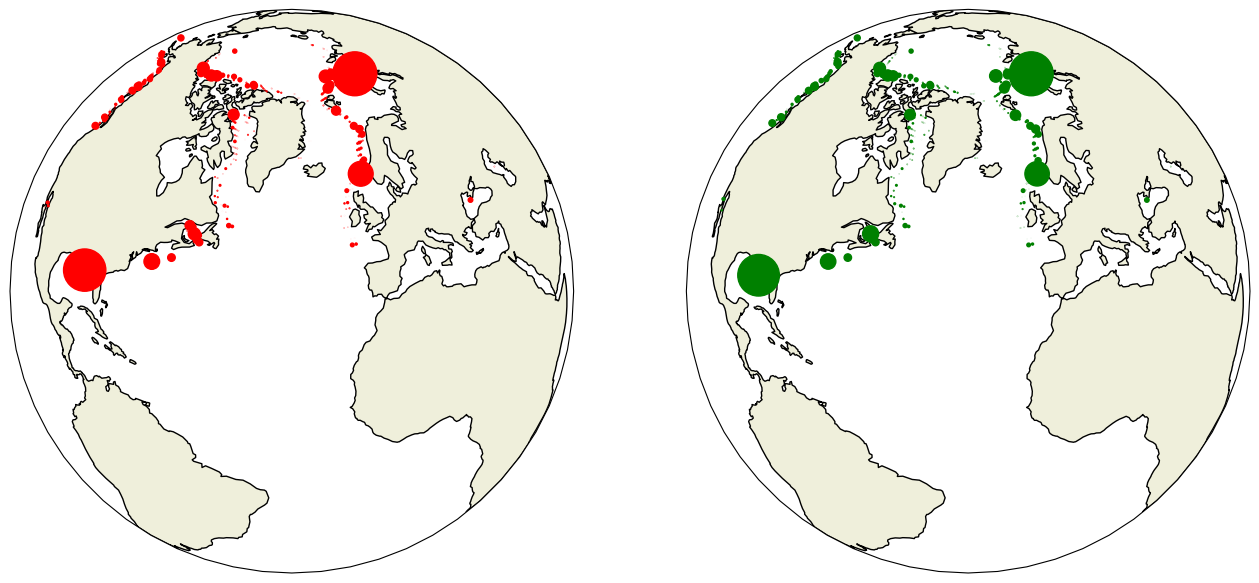

In [27]:
shifted_mask = routing.overlapping_method(hadcm3_mask, lsm, mode_lon="double", mode_shape="cross", verbose=True)

projection_map = ccrs.Orthographic(central_longitude=-30.0, central_latitude=40.0)

figMap,(axOut, axShifted) = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection':projection_map}, figsize=(16,8))

x,y,s = plotting.scatter_mask(hadcm3_mask)
axOut.scatter(lon_lsm[x], lat_lsm[y], transform=ccrs.PlateCarree(), s=s, color="red")
axOut.set_global()
axOut.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

x,y,s = plotting.scatter_mask(shifted_mask)
axShifted.scatter(lon_lsm[x], lat_lsm[y], transform=ccrs.PlateCarree(), s=s, color="green")
axShifted.set_global()
axShifted.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')

print(f"Before shifting -> flux : {np.nansum(hadcm3_mask):.2f} , max : {np.nanmax(hadcm3_mask):.2f}")
print(f"After shifting  -> flux : {np.nansum(shifted_mask):.2f} , max : {np.nanmax(shifted_mask):.2f}")

Text(0.5, 1.0, 'Pure Meltwater Points at -18 kya')

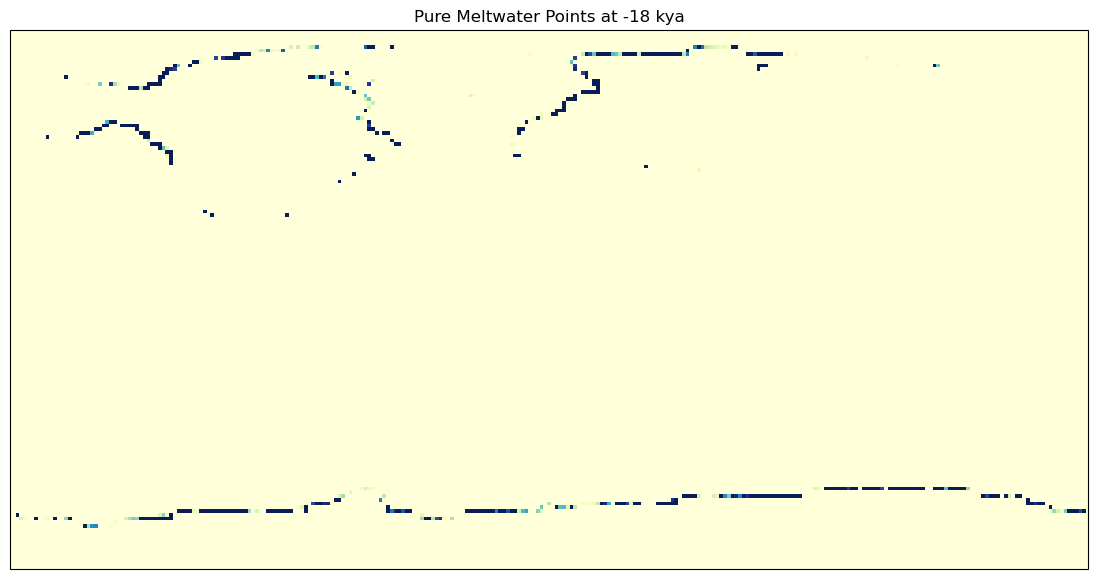

In [41]:
projection_map = ccrs.PlateCarree()
figMap,axMap = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection':projection_map}, figsize=(14,7))

cmap = axMap.pcolormesh(lon_lsm_b, lat_lsm_b,shifted_mask, transform=ccrs.PlateCarree(), cmap="YlGnBu", 
                                    clim=(0, 5), alpha=1)
axMap.set_global()
axMap.set_title(f"Pure Meltwater Points at {snap} kya")


#hadcm3_mask.shape

In [49]:
#Save as netcdf
data = xr.DataArray(shifted_mask, 
coords={'latitude': lat_lsm,'longitude': lon_lsm},
dims=["latitude", "longitude"])
data.to_netcdf("pointMW18.nc")



In [43]:
shifted_mask.shape

(144, 288)